In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [279]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import os
import requests
import phik
from phik import resources, report
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

RANDOM_STATE = 1220

In [3]:
data_path_local = './datasets/autos.csv'
data_path_web = 'https://code.s3.yandex.net/datasets/6_class.csv'

if os.path.exists(data_path_local):
    data = pd.read_csv(data_path_local, index_col = 'Unnamed: 0')
elif requests.head(data_path_web).status_code == 200:
    data = pd.read_csv(data_path_web, index_col = 'Unnamed: 0')
else:
    print('Something is wrong')

In [4]:
def info_df(df):
    print('------------------------------')
    print('| Информация о наборе данных |')
    print('------------------------------')
    df.info()
    print('-----------------------------------------')
    print('| Первые и последние 5 строчек датасета |')
    print('-----------------------------------------')
    display(df)
    print('--------------------')
    print('| Сумма дубликатов |')
    print('--------------------')
    print(df.duplicated().sum())

In [5]:
info_df(data)

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB
-----------------------------------------
| Первые и последние 5 строчек датасета |
-----------------------------------------


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue
236,30839,834042.000000,1194.0000,-10.63,5,Blue
237,8829,537493.000000,1423.0000,-10.73,5,White
238,9235,404940.000000,1112.0000,-11.23,5,White


--------------------
| Сумма дубликатов |
--------------------
0


In [6]:
print('--------------------------------')
print('|  Доля пропущенных значений.  |')
print('--------------------------------')
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

--------------------------------
|  Доля пропущенных значений.  |
--------------------------------


,0
Temperature (K),0.000000
Luminosity(L/Lo),0.000000
Radius(R/Ro),0.000000
Absolute magnitude(Mv),0.000000
Star type,0.000000
Star color,0.000000


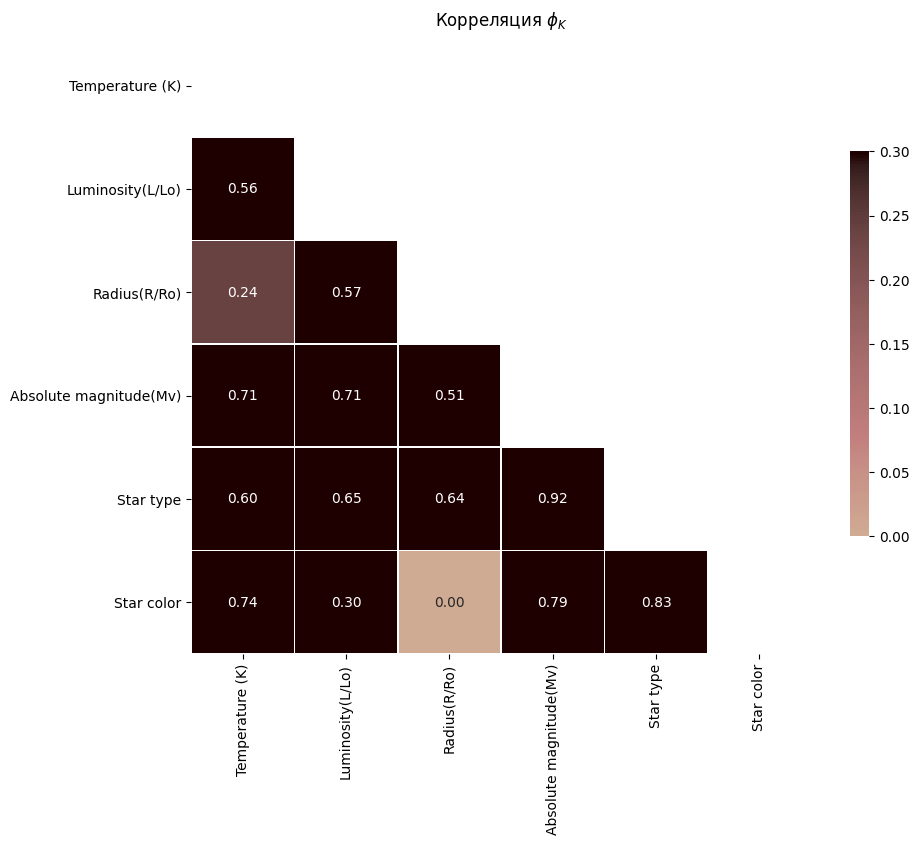

In [7]:
interval_cols = data.columns[:-2] # Без типа и цвета звезды
phik_overview = data.phik_matrix(interval_cols=interval_cols)



plt.figure(figsize=(10, 10))
plt.title(r'Корреляция $\phi_K$')
corr = phik_overview.round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
sb.heatmap(corr, mask=mask, cmap='pink_r', vmax=.3, center=0,
        annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

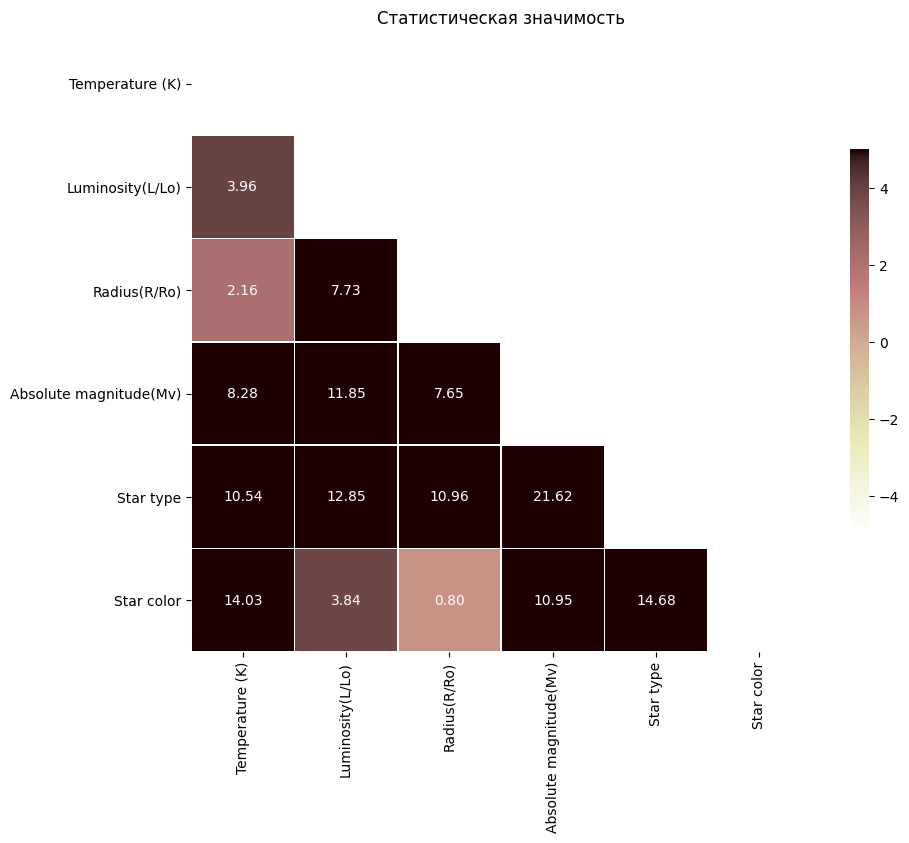

In [8]:
significance_overview  = data.significance_matrix(interval_cols=interval_cols)

plt.figure(figsize=(10, 10))
plt.title('Статистическая значимость')
corr = significance_overview.round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
sb.heatmap(corr, mask=mask, cmap='pink_r', vmax=5, vmin=-5, center=0,
           annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

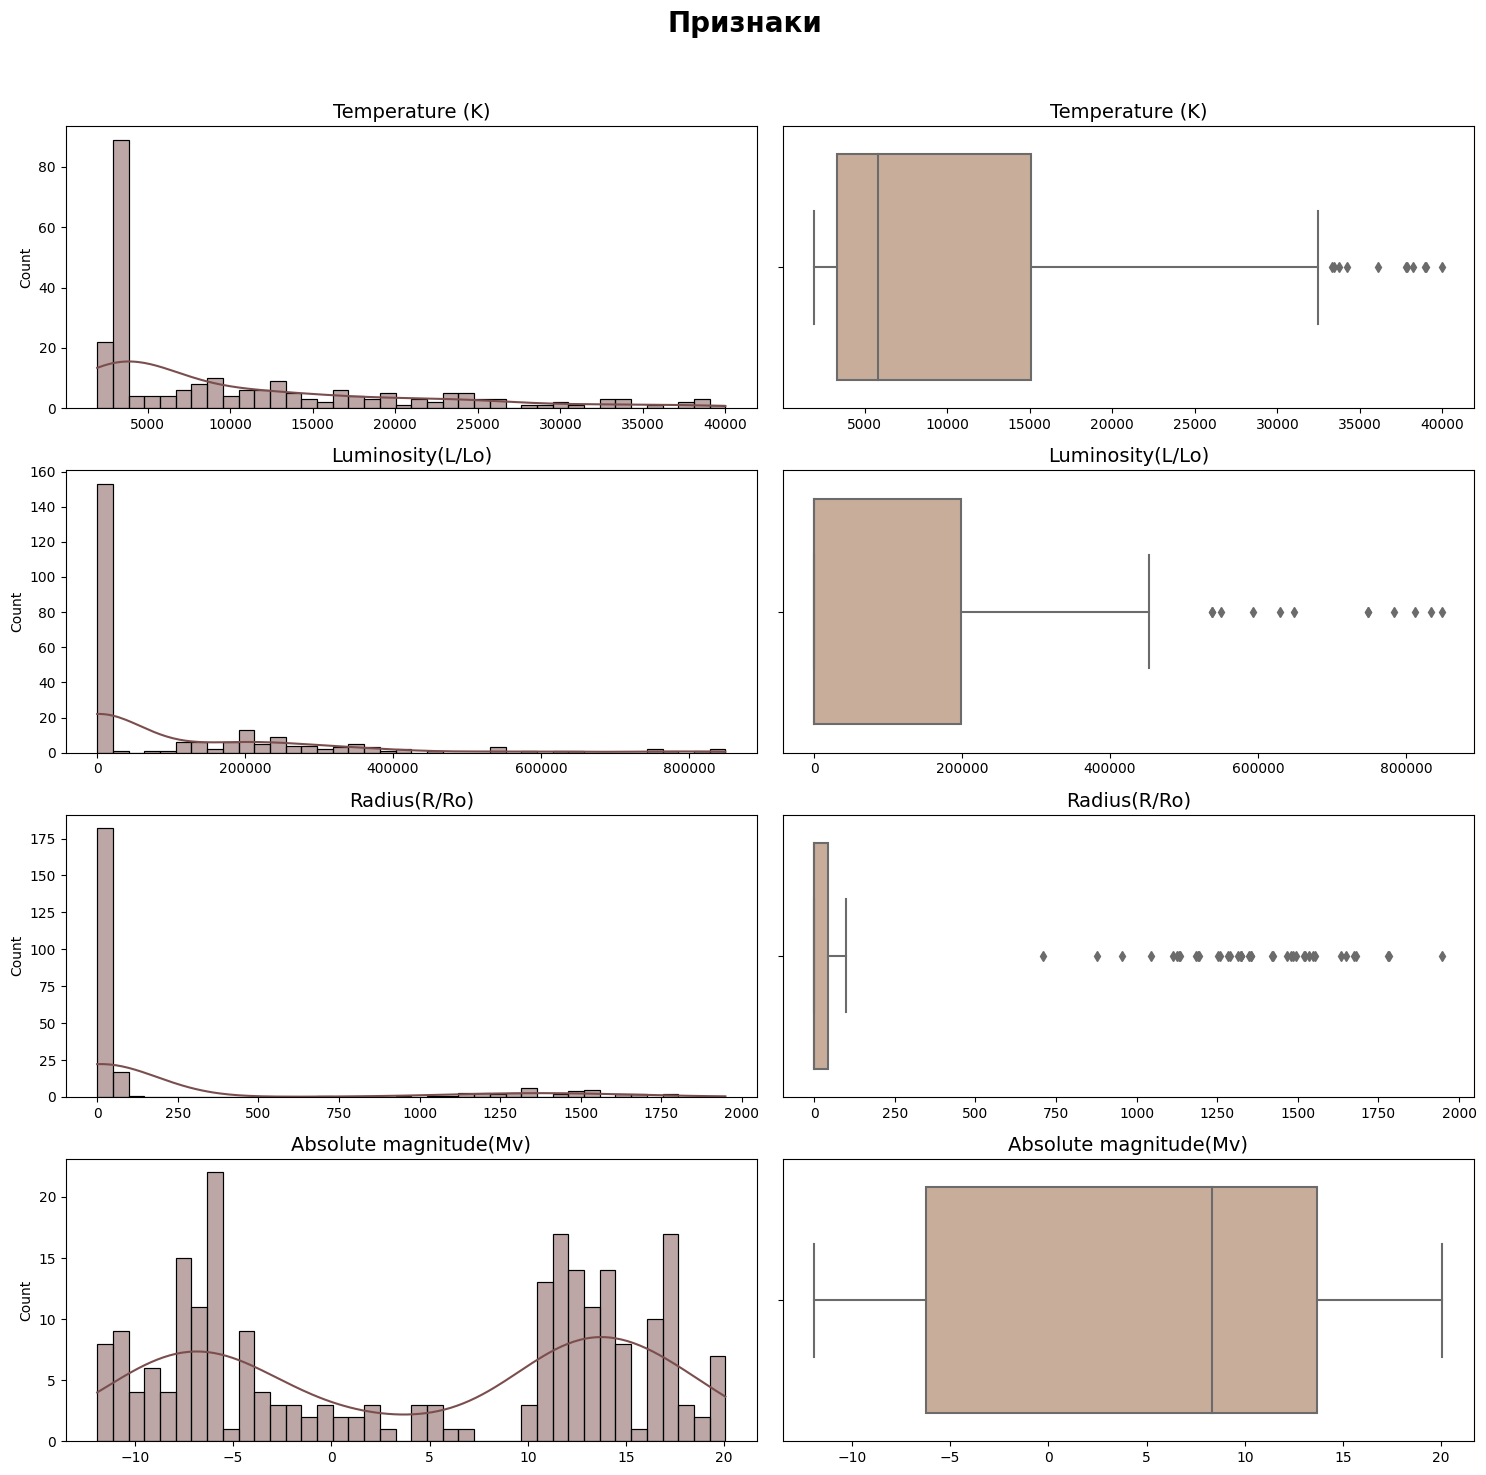

In [9]:
fig, axes = plt.subplots(nrows=len(data[interval_cols].columns), ncols=2, figsize=(15, 15))
j = 0
for i in data[interval_cols].columns:
    sb.histplot(data[interval_cols][i], ax=axes[j, 0], kde=True, bins=40, edgecolor='black', color=sb.color_palette("pink")[0])
    axes[j, 0].set_title(i, fontsize=14)
    axes[j, 0].set_xlabel('')

    sb.boxplot(x=data[interval_cols][i], ax=axes[j, 1], orient='h', palette="pink")
    axes[j, 1].set_title(i, fontsize=14)
    axes[j, 1].set_xlabel('')
    j += 1

plt.suptitle(f'Признаки\n\n', ha='center', fontweight='bold', fontsize=20)
plt.tight_layout()
plt.show()

In [10]:
data[interval_cols].describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
count,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396
std,9552.425037,179432.244940,517.155763,10.532512
min,1939.000000,0.000080,0.008400,-11.920000
25%,3344.250000,0.000865,0.102750,-6.232500
50%,5776.000000,0.070500,0.762500,8.313000
75%,15055.500000,198050.000000,42.750000,13.697500
max,40000.000000,849420.000000,1948.500000,20.060000


In [11]:
features = data.drop(['Temperature (K)'], axis = 1)
target = data['Temperature (K)']

In [12]:
features_train, features_test, target_train, target_test \
    = train_test_split(features, target, test_size = 0.25, random_state = RANDOM_STATE)

In [13]:
ohe_features = features.select_dtypes(include='object').columns.to_list()
print(ohe_features)
num_features = features.select_dtypes(exclude='object').columns.to_list()
num_features

['Star color']


['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Star type']

In [14]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
features_ohe_train = features_train.copy()

encoder_ohe.fit(features_ohe_train[ohe_features])

transformed = encoder_ohe.transform(features_ohe_train[ohe_features])

ohe_df = pd.DataFrame(transformed, columns = encoder_ohe.get_feature_names_out(), index = features_ohe_train.index)

features_ohe_train = pd.concat([features_ohe_train, ohe_df], axis=1).drop(ohe_features, axis=1)

In [15]:
features_ohe_test = features_test.copy()
transformed = encoder_ohe.transform(features_ohe_test[ohe_features])

ohe_df = pd.DataFrame(transformed, columns = encoder_ohe.get_feature_names_out(), index = features_ohe_test.index)

features_ohe_test = pd.concat([features_ohe_test, ohe_df], axis=1).drop(ohe_features, axis=1)

c:\ProgramData\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [16]:
vif_data = pd.DataFrame()
vif_data["feature"] = features_ohe_train.columns

# вычисление VIF для каждого признака
vif_data["VIF"] = [variance_inflation_factor(features_ohe_train.values, i) \
                          for i in range(len(features_ohe_train.columns))]

print(vif_data)

                          feature       VIF
0                Luminosity(L/Lo)  3.247447
1                    Radius(R/Ro)  2.692725
2          Absolute magnitude(Mv)  4.937753
3                       Star type  8.078022
4                Star color_Blue   1.069615
5           Star color_Blue White  1.750514
6           Star color_Blue white  1.266782
7          Star color_Blue white   1.069887
8           Star color_Blue-White  1.044956
9           Star color_Blue-white  1.513857
10              Star color_Orange  1.081928
11          Star color_Orange-Red  1.063205
12  Star color_Pale yellow orange  1.089827
13                 Star color_Red  4.643120
14               Star color_White  1.421709
15        Star color_White-Yellow  1.089906
16             Star color_Whitish  1.097592
17           Star color_Yellowish  1.063704
18     Star color_Yellowish White  1.171028
19               Star color_white  1.161911
20        Star color_yellow-white  1.403004


In [229]:
X_train, X_test, Y_train, Y_test = torch.tensor(features_ohe_train.values, dtype=torch.float32),\
                                   torch.tensor(features_ohe_test.values, dtype=torch.float32),\
                                   torch.tensor(target_train.values, dtype=torch.float32),\
                                   torch.tensor(target_test.values, dtype=torch.float32)

In [280]:
scaler = StandardScaler()
X_train_slr = torch.tensor(scaller.fit_transform(X_train), dtype=torch.float32)
X_test_slr = torch.tensor(scaller.transform(X_test), dtype=torch.float32)

In [120]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train - mean)/ std
X_test = (X_test - mean)/ std

In [281]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim: int, hidden_lyrs: list[int], output_dim: int, batch_norm=False, dropout=False):
        super(NeuralNet, self).__init__()
        if batch_norm == False and dropout == False:
            self.relu = nn.ReLU()
            if len(hidden_lyrs) > 1:
                self.syn_in = nn.Linear(input_dim, hidden_lyrs[0])
                self.hidden_syns = [nn.Linear(hidden_lyrs[i], hidden_lyrs[i+1]) for i in range(0, len(hidden_lyrs)-1)]
                self.syn_out = nn.Linear(hidden_lyrs[-1], output_dim)
            else:
                self.syn_in = nn.Linear(input_dim, hidden_lyrs[0])
                self.hidden_syns = []
                self.syn_out = nn.Linear(hidden_lyrs[0], output_dim)
        elif batch_norm == True and dropout == False:
            self.relu = nn.ReLU()
            self.btnr = []
            if len(hidden_lyrs) > 1:
                self.syn_in = nn.Linear(input_dim, hidden_lyrs[0])
                self.btnr = [nn.BatchNorm1d(i) for i in range(len(hidden_lyrs))]
                self.hidden_syns = [nn.Linear(hidden_lyrs[i], hidden_lyrs[i+1]) for i in range(len(hidden_lyrs)-1)]
                self.syn_out = nn.Linear(hidden_lyrs[-1], output_dim)
            else:
                self.syn_in = nn.Linear(input_dim, hidden_lyrs[0])
                self.btnr = nn.BatchNorm1d(hidden_lyrs[0])
                self.hidden_syns = []
                self.syn_out = nn.Linear(hidden_lyrs[0], output_dim)


    def forward(self, x):
        out = self.relu(self.syn_in(x))
        if len(self.hidden_syns) > 1:
            for syn in self.hidden_syns:
                out = self.relu(syn(out))
        return self.relu(self.syn_out(out))

In [232]:
def TrainModel(model, criterion, optimizer, X, Y, epochs):
    for i in range(epochs):
        optimizer.zero_grad()

        preds = model(X).flatten()

        loss = criterion(preds.ravel(), Y)


        loss.backward()

        optimizer.step()

        if i % 10000 == 0:
            print("RMSE : {:.2f}".format(torch.sqrt(loss)))

In [282]:
model = NeuralNet(input_dim=features, hidden_lyrs=[50,25,10], output_dim=1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

TrainModel(model, criterion, optimizer, X_train_slr, Y_train, epochs=200000)

RMSE : 14259.16
RMSE : 12593.43
RMSE : 11093.73
RMSE : 9230.76
RMSE : 7980.39
RMSE : 7259.01
RMSE : 6710.36
RMSE : 6124.32
RMSE : 5548.57
RMSE : 5026.20
RMSE : 4601.86
RMSE : 4328.39
RMSE : 4161.36
RMSE : 4016.57
RMSE : 3913.48
RMSE : 3830.95
RMSE : 3765.78
RMSE : 3710.26
RMSE : 3654.59
RMSE : 3614.09


In [283]:
train_preds = model(X_train_slr)
test_preds = model(X_test_slr)

In [284]:
print("RMSE Train: {0:.2f}.". \
      format((mean_squared_error(Y_train.detach().numpy(), train_preds.detach().numpy().squeeze()))**0.5))
print("RMSE Test: {0:.2f}.". \
      format((mean_squared_error(Y_test.detach().numpy(), test_preds.detach().numpy().squeeze()))**0.5))

RMSE Train: 3575.66.
RMSE Test: 4543.39.


In [285]:
def show_graph(test_preds):
    start = 0
    end = 15

    basic_df = Y_test[start:end]
    nn_df = test_preds[start:end]

    plt.figure(figsize=(7, 7))
    plt.bar(range(start, end), nn_df.detach().numpy().squeeze(), color='#FFA500', label='Прогноз')
    plt.bar(range(start, end), basic_df.detach().numpy(), color='#E6DAA6', width=0.5, label='Факт')

    plt.legend()
    plt.title('Факт-Прогноз', fontsize=16)
    plt.xlabel('Номер звезды в таблице данных', fontsize=14)
    plt.ylabel('Температура звезды', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

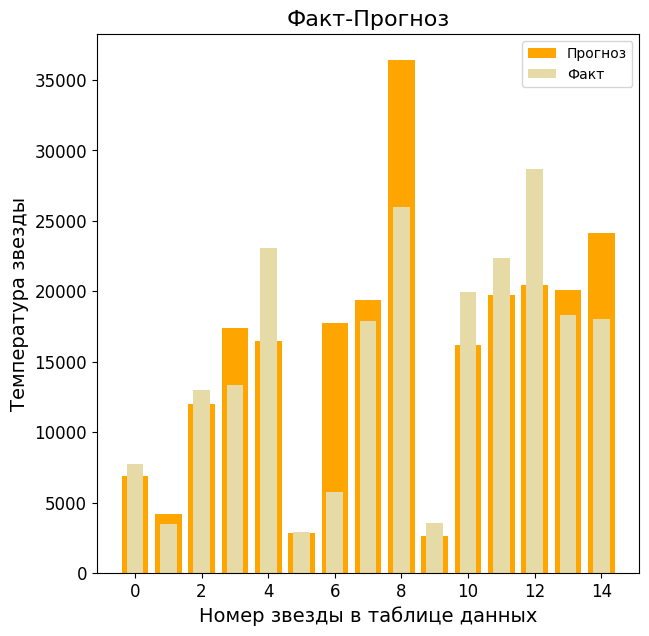

In [286]:
show_graph(test_preds)

In [288]:
model = NeuralNet(input_dim=features, hidden_lyrs=[50,25,10], output_dim=1, batch_norm=True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

TrainModel(model, criterion, optimizer, X_train_slr, Y_train, epochs=200000)

RMSE : 14259.27
RMSE : 12787.94
RMSE : 11707.13
RMSE : 10186.38
RMSE : 8698.83
RMSE : 7842.29
RMSE : 7309.57
RMSE : 6859.22
RMSE : 6402.87
RMSE : 5920.68
RMSE : 5428.29
RMSE : 4982.74
RMSE : 4612.20
RMSE : 4322.43
RMSE : 4112.97
RMSE : 3962.32
RMSE : 3851.16
RMSE : 3755.03
RMSE : 3665.19
RMSE : 3589.53


In [289]:
train_preds_bn = model(X_train_slr)
test_preds_bn = model(X_test_slr)

In [290]:
print("RMSE Train: {0:.2f}.". \
      format((mean_squared_error(Y_train.detach().numpy(), train_preds_bn.detach().numpy().squeeze()))**0.5))
print("RMSE Test: {0:.2f}.". \
      format((mean_squared_error(Y_test.detach().numpy(), test_preds_bn.detach().numpy().squeeze()))**0.5))

RMSE Train: 3529.23.
RMSE Test: 4671.15.


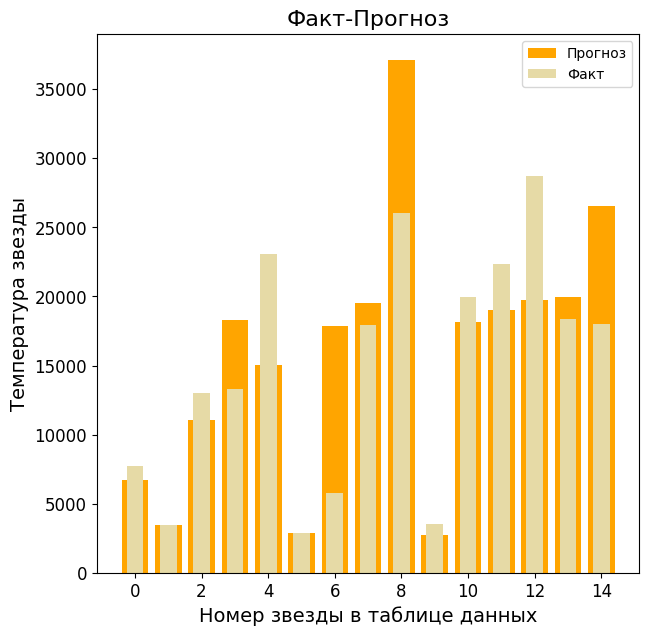

In [291]:
show_graph(test_preds_bn)